In [9]:
%matplotlib inline
%run 'bin/notebook_utils.py'

In [10]:
# Load wrangled data saved in .csv files for scheduling experiment sessions
sch_sessions = pd.read_csv('data/scheduler/sessions.csv', index_col=0)
sch_pilots = pd.read_csv('data/scheduler/pilots.csv', index_col=0)
sch_units = pd.read_csv('data/scheduler/units.csv', index_col=0)

In [11]:
print 'Scheduler: Total number of successful runs: %s' % sch_sessions.shape[0]
print 'Scheduler: Total number of pilots: %s' % sch_pilots.shape[0]
print 'Scheduler: Total number of units: %s\n' % sch_units.shape[0]

Scheduler: Total number of successful runs: 1
Scheduler: Total number of pilots: 1
Scheduler: Total number of units: 256



In [12]:
sch = sch_sessions[
    ['nunit','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING']
        ].groupby(['nunit']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std']})

sch.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
sch.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)
sch.rename(index={i: '%s/%s' % (i, i*32) for i in ss.index.get_values()}, inplace=True)
sch

TTQ     Agent queueing     Agent queueing execution            TTX             TTC     Agent scheduling    
             mean std           mean std                     mean std       mean std        mean std             mean std
nunit                                                                                                                    
256    23676.0705 NaN        11.0161 NaN                   4.8353 NaN  1316.2753 NaN  25073.1539 NaN           3.1768 NaN

In [16]:
import sys
import pprint

import matplotlib.pyplot as plt
import numpy             as np

import radical.utils     as ru
import radical.pilot     as rp
import radical.analytics as ra

from   radical.utils.profile import *
from   radical.pilot.states  import *

UNIT_DURATIONS = {
        'exec-tot' : [{STATE: AGENT_EXECUTING,              EVENT: 'state'        },
                      {STATE: AGENT_STAGING_OUTPUT_PENDING, EVENT: 'state'        }],
        'exec-rp'  : [{STATE: None,                         EVENT: 'exec_start'   },
                      {STATE: None,                         EVENT: 'exec_stop'    }],
        'exec-cu'  : [{STATE: None,                         EVENT: 'cu_start'     },
                      {STATE: None,                         EVENT: 'cu_exec_stop' }],
        'exec-orte': [{STATE: None,                         EVENT: 'cu_exec_start'},
                      {STATE: None,                         EVENT: 'cu_exec_stop' }],
        'exec-app' : [{STATE: None,                         EVENT: 'app_start'    },
                      {STATE: None,                         EVENT: 'app_stop'     }]}

data    = dict()
sch_path = '../rawdata/scheduling/'

sources = ['%s/ws_syn_titan_256_32_8192_60_1.0' % sch_path,]

for dname in UNIT_DURATIONS:
    data[dname]  = list()

# get the numbers we actually want to plot
fout = open('outliers.dat', 'w')
ucnt = 0
ocnt = 0
for src in sources:
    # always point to the tarballs
    if src[-4:] != '.tbz':
        src += '.tbz'

#     print
#     print '-----------------------------------------------------------'
#     print src

    session = ra.Session(src, 'radical.pilot')
    units   = session.filter(etype='unit', inplace=True)
    sid     = session.uid

    for unit in units.get():
        for dname in UNIT_DURATIONS:
            dur = unit.duration(event=UNIT_DURATIONS[dname])
            if dur > 1000.0:
                ocnt += 1
                fout.write('%10.1f  %s\n' % (dur, src))
                fout.flush()
#                 sys.stdout.write('#')
            else:
                ucnt += 1
                data[dname].append(dur)
#                 sys.stdout.write('.')
            sys.stdout.flush()

ValueError: no duration defined for given constraints

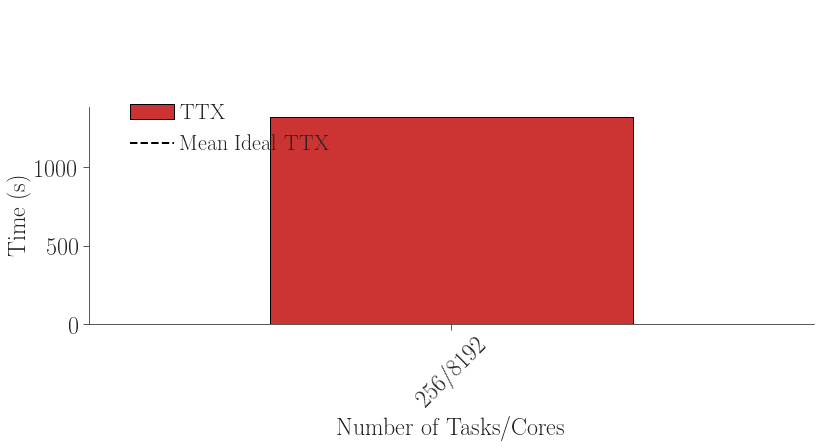

In [8]:
fig, ax = fig_setup(figsize=(13,4))

ax1 = ss['TTX'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    width=0.5, color=tableau20[6], ax=ax, rot=45, legend=False)

# ax1.axhline(y=np.mean(data['exec-app']), lw=1.5, color='black', ls='dashed')

ax.set_xlabel('Number of Tasks/Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

fig.legend((mpl.patches.Patch(facecolor=tableau20[6]),
            mpl.lines.Line2D([], [], color='black', linestyle='dashed')),
           ('TTX', 'Mean Ideal TTX'), 
           'upper left',
           columnspacing=0.75,
           handletextpad=0.3,
           bbox_to_anchor=(0.1175, 1.265))